In [1]:
# Reads CT test images and labels, and saves them in tf-record format similar to the training/validation images
# The data will be saved under 'ct_atlas_train_tfs' and 'ct_atlas_test_tfs', with corresponding slice lists
# Follows the code at https://github.com/cchen-cc/SIFA/blob/SIFA-v1/evaluate.py

In [2]:
# https://stackoverflow.com/questions/37893755/tensorflow-set-cuda-visible-devices-within-jupyter
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

# https://stackoverflow.com/questions/56008683/could-not-create-cudnn-handle-cudnn-status-internal-error
import tensorflow as tf
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.95)
config = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [3]:
import numpy as np

import augmentations as aug
import data_utils

import tensorflow as tf
import nibabel as nib

import io_utils as io
from PIL import Image
import cv2

import importlib

import os

In [4]:
import SimpleITK as sitk
import scipy.ndimage as ndimage

In [5]:
dataset_seed = 0

raw_ct_img_dir = "./data/abdomen/raw-data/RawData/Training/"

data_dir = "./data/abdomen/processed-data/"

train_file_list = "./data/abdomen/processed-data/ct_atlas_train_list"
test_file_list = "./data/abdomen/processed-data/ct_atlas_test_list"

In [6]:
# we use the following final mapping for labels
label_ids_abdomen = {"ignore": 0,
    "liver": 1,
    "right_kidney": 2,
    "left_kidney": 3,
    "spleen": 4,
 }

# The current dataset uses the following class mapping:
# (1) spleen
# (2) right kidney
# (3) left kidney
# (4) gallbladder
# (5) esophagus
# (6) liver
# (7) stomach
# (8) aorta
# (9) inferior vena cava
# (10) portal vein and splenic vein
# (11) pancreas
# (12) right adrenal gland
# (13) left adrenal gland

# So, we only need to change labels as follows: 6 -> 1, 1-> 4. 

In [7]:
# Split 80% of the scans for training, and 20% for testing

np.random.seed(dataset_seed)

train_indices = sorted(np.random.choice(range(30), 24, replace=False))
test_indices = np.asarray(sorted([x for x in range(30) if x not in train_indices]))

train_images = np.asarray(sorted(os.listdir(raw_ct_img_dir + "img/")))[train_indices]
train_labels = np.asarray(sorted(os.listdir(raw_ct_img_dir + "label/")))[train_indices]

test_images = np.asarray(sorted(os.listdir(raw_ct_img_dir + "img/")))[test_indices]
test_labels = np.asarray(sorted(os.listdir(raw_ct_img_dir + "label/")))[test_indices]

In [8]:
def preprocess_ct(imf, labelf, final_cropping=True):
    # CT specific processing - code from
    # https://github.com/assassint2017/abdominal-multi-organ-segmentation/blob/master/data_perpare/get_data.py
    upper = 275
    lower = -125
    slice_thickness = 3
    down_scale = 0.5
    expand_slice = 10
    
    ct = sitk.ReadImage(raw_ct_img_dir + "img/" + imf, sitk.sitkInt16)
    ct_array = sitk.GetArrayFromImage(ct)

    seg = sitk.ReadImage(raw_ct_img_dir + "label/" + labelf, sitk.sitkInt8)
    seg_array = sitk.GetArrayFromImage(seg)
    
    print("original shape", ct_array.shape)
    
    # 对CT和金标准使用插值算法进行插值来统一轴向的spacing，插值之后的array依然是int类型
#     ct_array = ndimage.zoom(ct_array, (ct.GetSpacing()[-1] / slice_thickness, down_scale, down_scale), order=3)
    ct_array = ndimage.zoom(ct_array, (1, down_scale, down_scale), order=3)

    # 对金标准插值不应该使用高级插值方式，这样会破坏边界部分，总之这次错误也说明了检查数据的重要性
#     seg_array = ndimage.zoom(seg_array, (ct.GetSpacing()[-1] / slice_thickness, down_scale, down_scale), order=0)
    seg_array = ndimage.zoom(seg_array, (1, down_scale, down_scale), order=0)

    # 将灰度值在阈值之外的截断掉
    ct_array[ct_array > upper] = upper
    ct_array[ct_array < lower] = lower
    
    print("shape after zooming", ct_array.shape)
    
    ############################################################################
    # Older pre-processing
    scan = np.copy(ct_array)
    labels = np.copy(seg_array)
    
    # Keep only four classes
    adjusted_labels = np.zeros(labels.shape, dtype=np.int32)
    adjusted_labels[labels == 6] = 1
    adjusted_labels[labels == 2] = 2
    adjusted_labels[labels == 3] = 3
    adjusted_labels[labels == 1] = 4
    labels = np.copy(adjusted_labels)
    
    print(scan.shape, labels.shape)
    
    # Make the immages channel last
    scan = np.moveaxis(scan, 0, -1)
    labels = np.moveaxis(labels, 0, -1)
    
    # Adjust scan alignment
    scan = np.flip(scan, 0)
    labels = np.flip(labels, 0)
    
    print(scan.shape, labels.shape)
    
    # Normalize the image
    print(np.shape(scan))
    print(np.min(scan), np.max(scan))
    print(np.mean(scan), np.std(scan))
    
    scan = data_utils.normalize(scan)
    
    print(np.min(scan), np.max(scan))
    print(np.mean(scan), np.std(scan))
    print()
    
    if final_cropping:
        # Remove 0 label space around the image
        # From a 256x256xC scan, space is removed 30 units up, down, left or right of the furthest labeled pixel
        # Then, the image is resized back to 256x256
        
        imin = 1000
        imax = 0
        jmin = 1000
        jmax = 0
        for c in range(scan.shape[-1]):
            for i in range(scan.shape[0]):
                for j in range(scan.shape[1]):
                    if labels[i,j,c] != 0:
                        imin = min(imin, i)
                        imax = max(imax, i)
                        jmin = min(jmin, j)
                        jmax = max(jmax, j)
        
        # Add extra buffer around the labeled regions
        disp = 30
        imin = max(imin - disp, 0)
        imax = min(imax + disp, scan.shape[0])
        jmin = max(jmin - disp, 0)
        jmax = min(jmax + disp, scan.shape[1])
        
        print(imin, imax, jmin, jmax)
        
        # Remove some extra space on the border of the images
        for c in range(scan.shape[-1]):
            scan[...,c] = cv2.resize(scan[...,c][imin:imax,jmin:jmax], (256,256), interpolation=cv2.INTER_CUBIC)
            labels[...,c] = cv2.resize(labels[...,c][imin:imax,jmin:jmax], (256,256), interpolation=cv2.INTER_NEAREST)

    # Compare current image with ct_array and ct_labels
    sind = 20
    _, ax = plt.subplots(1,4)
    ax[0].imshow(np.flip(ct_array, 1)[sind])
    ax[1].imshow(np.flip(seg_array, 1)[sind], vmin=0, vmax=5) # this may have non normalized labels
    ax[2].imshow(scan[...,sind])
    ax[3].imshow(labels[...,sind], vmin=0, vmax=5)
    plt.show()
    
    return scan,labels

Working on a new scan img0002.nii label0002.nii
original shape (139, 512, 512)
shape after zooming (139, 256, 256)
(139, 256, 256) (139, 256, 256)
(256, 256, 139) (256, 256, 139)
(256, 256, 139)
-125 275
-69.56155351597629 99.93991474624433
-0.5547177684190194 3.0
-0.011298428273095277 0.9629160662804089

34 199 16 242


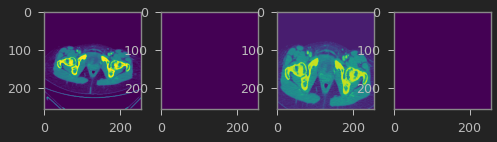

Working on a new scan img0003.nii label0003.nii
original shape (198, 512, 512)
shape after zooming (198, 256, 256)
(198, 256, 256) (198, 256, 256)
(256, 256, 198) (256, 256, 198)
(256, 256, 198)
-125 275
-77.9934028856682 87.8967625523679
-0.5347932705294556 3.0
-0.01921400649721541 0.9308770757919003

48 227 13 247


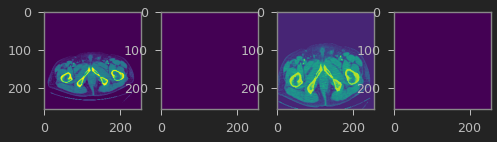

Working on a new scan img0005.nii label0005.nii
original shape (117, 512, 512)
shape after zooming (117, 256, 256)
(117, 256, 256) (117, 256, 256)
(256, 256, 117) (256, 256, 117)
(256, 256, 117)
-125 275
-75.29795798277243 87.67533362950076
-0.5668874010478127 3.0
-0.01732739236493632 0.9382525883463421

23 213 0 240


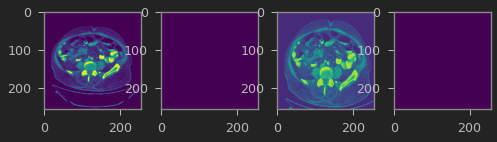

Working on a new scan img0006.nii label0006.nii
original shape (131, 512, 512)
shape after zooming (131, 256, 256)
(131, 256, 256) (131, 256, 256)
(256, 256, 131) (256, 256, 131)
(256, 256, 131)
-125 275
-67.7440447625313 103.93746483404534
-0.5508692686404081 3.0
-0.0088774725037321 0.9716447509838003

92 246 11 248


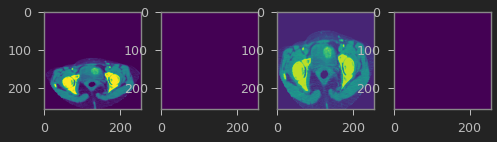

Working on a new scan img0007.nii label0007.nii
original shape (163, 512, 512)
shape after zooming (163, 256, 256)
(163, 256, 256) (163, 256, 256)
(256, 256, 163) (256, 256, 163)
(256, 256, 163)
-125 275
-59.68743110141871 91.16868561214983
-0.7163925690059227 3.0
-0.01617101923616654 0.9446140618997961

32 238 0 256


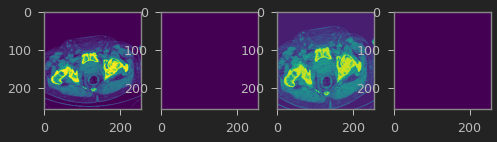

Working on a new scan img0008.nii label0008.nii
original shape (148, 512, 512)
shape after zooming (148, 256, 256)
(148, 256, 256) (148, 256, 256)
(256, 256, 148) (256, 256, 148)
(256, 256, 148)
-125 275
-73.49826554994326 96.25551968902909
-0.5350522714587427 3.0
-0.015788784601993566 0.9464908458958806

27 196 6 249


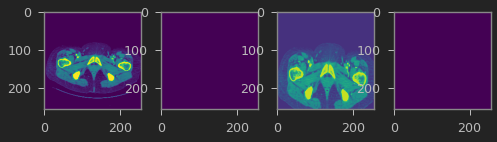

Working on a new scan img0009.nii label0009.nii
original shape (149, 512, 512)
shape after zooming (149, 256, 256)
(149, 256, 256) (149, 256, 256)
(256, 256, 149) (256, 256, 149)
(256, 256, 149)
-125 275
-75.85029356271629 82.98200331634087
-0.5922935633394756 3.0
-0.012784773815336143 0.953493526323269

47 224 23 244


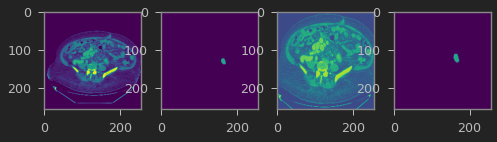

Working on a new scan img0010.nii label0010.nii
original shape (148, 512, 512)
shape after zooming (148, 256, 256)
(148, 256, 256) (148, 256, 256)
(256, 256, 148) (256, 256, 148)
(256, 256, 148)
-125 275
-68.61477712682776 87.67068751077183
-0.6431479491505568 3.0
-0.01800507511260322 0.9360861435199526

48 223 4 244


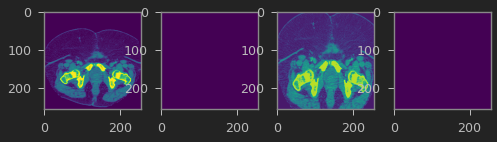

Working on a new scan img0021.nii label0021.nii
original shape (143, 512, 512)
shape after zooming (143, 256, 256)
(143, 256, 256) (143, 256, 256)
(256, 256, 143) (256, 256, 143)
(256, 256, 143)
-125 275
-64.3087387618485 106.70435734396587
-0.5687795957808052 3.0
-0.004892991673712414 0.9847670792988222

46 213 12 245


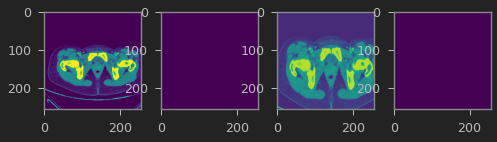

Working on a new scan img0022.nii label0022.nii
original shape (89, 512, 512)
shape after zooming (89, 256, 256)
(89, 256, 256) (89, 256, 256)
(256, 256, 89) (256, 256, 89)
(256, 256, 89)
-125 275
-68.5842010840941 92.23882725554114
-0.6116274522832984 3.0
-0.014187689775001695 0.9512899252214866

12 194 0 240


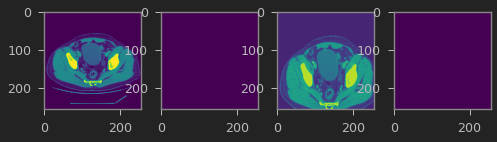

Working on a new scan img0024.nii label0024.nii
original shape (124, 512, 512)
shape after zooming (124, 256, 256)
(124, 256, 256) (124, 256, 256)
(256, 256, 124) (256, 256, 124)
(256, 256, 124)
-125 275
-75.97370406120054 89.12125808898503
-0.5501077631764142 3.0
-0.020482596038680616 0.9268510879397255

44 221 15 256


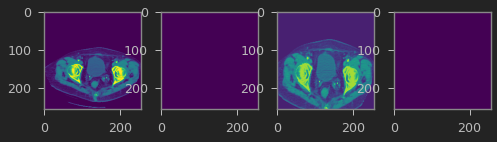

Working on a new scan img0025.nii label0025.nii
original shape (85, 512, 512)
shape after zooming (85, 256, 256)
(85, 256, 256) (85, 256, 256)
(256, 256, 85) (256, 256, 85)
(256, 256, 85)
-125 275
-79.72111529181986 78.90772817341669
-0.5738206606160308 3.0
-0.0268534612465521 0.8956247089284675

18 207 5 240


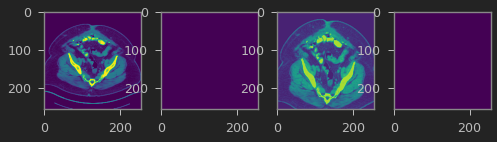

Working on a new scan img0027.nii label0027.nii
original shape (88, 512, 512)
shape after zooming (88, 256, 256)
(88, 256, 256) (88, 256, 256)
(256, 256, 88) (256, 256, 88)
(256, 256, 88)
-125 275
-68.38179050792347 91.85740295365959
-0.6163706753242244 3.0
-0.01295488749385646 0.9555913076753886

16 205 0 255


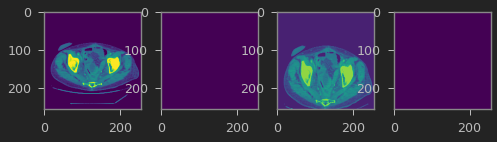

Working on a new scan img0028.nii label0028.nii
original shape (89, 512, 512)
shape after zooming (89, 256, 256)
(89, 256, 256) (89, 256, 256)
(256, 256, 89) (256, 256, 89)
(256, 256, 89)
-125 275
-80.42049073637202 80.14334512333765
-0.5562471742977756 3.0
-0.021316348902344157 0.9187269445666894

44 233 11 237


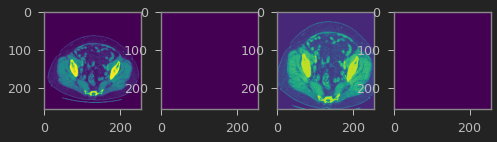

Working on a new scan img0029.nii label0029.nii
original shape (100, 512, 512)
shape after zooming (100, 256, 256)
(100, 256, 256) (100, 256, 256)
(256, 256, 100) (256, 256, 100)
(256, 256, 100)
-125 275
-87.46541351318359 80.37506091023369
-0.4669929460922791 3.0
-0.022192750707333463 0.9153250056411119

55 216 21 223


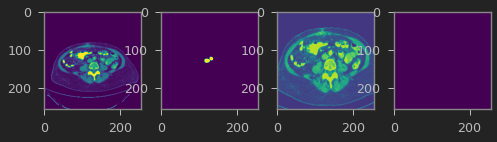

Working on a new scan img0030.nii label0030.nii
original shape (153, 512, 512)
shape after zooming (153, 256, 256)
(153, 256, 256) (153, 256, 256)
(256, 256, 153) (256, 256, 153)
(256, 256, 153)
-125 275
-57.93184706744026 102.63822792023346
-0.6534422338690664 3.0
-0.005215710302976448 0.9835825183568722

43 221 0 256


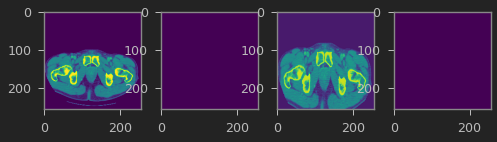

Working on a new scan img0031.nii label0031.nii
original shape (93, 512, 512)
shape after zooming (93, 256, 256)
(93, 256, 256) (93, 256, 256)
(256, 256, 93) (256, 256, 93)
(256, 256, 93)
-125 275
-81.96378137732064 83.4590173517852
-0.5156569054878622 3.0
-0.015576057502683835 0.9424842410528972

58 223 7 243


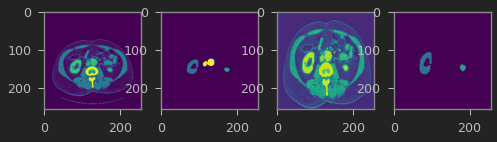

Working on a new scan img0033.nii label0033.nii
original shape (104, 512, 512)
shape after zooming (104, 256, 256)
(104, 256, 256) (104, 256, 256)
(256, 256, 104) (256, 256, 104)
(256, 256, 104)
-125 275
-61.23722883371207 93.89074402604544
-0.679116688526827 3.0
-0.01399059562063797 0.9529560100079647

22 209 5 254


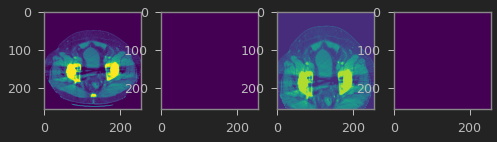

Working on a new scan img0034.nii label0034.nii
original shape (98, 512, 512)
shape after zooming (98, 256, 256)
(98, 256, 256) (98, 256, 256)
(256, 256, 98) (256, 256, 98)
(256, 256, 98)
-125 275
-51.84332415522361 100.02707177313958
-0.7313687639551721 3.0
-0.006059527720754934 0.9808279837531005

3 210 0 256


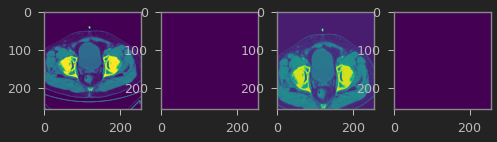

Working on a new scan img0035.nii label0035.nii
original shape (94, 512, 512)
shape after zooming (94, 256, 256)
(94, 256, 256) (94, 256, 256)
(256, 256, 94) (256, 256, 94)
(256, 256, 94)
-125 275
-86.92914711160863 79.79335828104965
-0.47711806732456985 3.0
-0.0242191871018161 0.9065902760959181

45 194 18 232


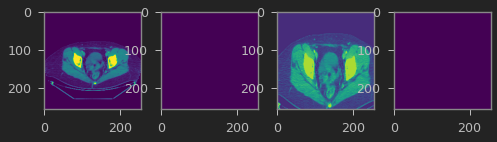

Working on a new scan img0037.nii label0037.nii
original shape (99, 512, 512)
shape after zooming (99, 256, 256)
(99, 256, 256) (99, 256, 256)
(256, 256, 99) (256, 256, 99)
(256, 256, 99)
-125 275
-62.99602300470526 98.97830453846389
-0.6264400798176879 3.0
-0.008828904470594362 0.9713088160520712

23 214 0 254


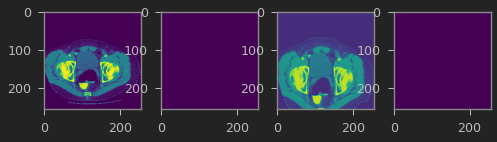

Working on a new scan img0038.nii label0038.nii
original shape (100, 512, 512)
shape after zooming (100, 256, 256)
(100, 256, 256) (100, 256, 256)
(256, 256, 100) (256, 256, 100)
(256, 256, 100)
-125 275
-70.07824020385742 85.69799246551614
-0.6408756870033154 3.0
-0.016451330714127445 0.9409264407156843

33 208 18 241


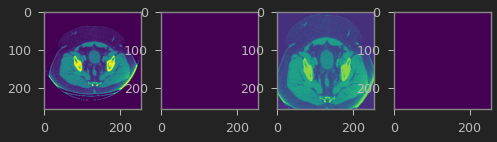

Working on a new scan img0039.nii label0039.nii
original shape (90, 512, 512)
shape after zooming (90, 256, 256)
(90, 256, 256) (90, 256, 256)
(256, 256, 90) (256, 256, 90)
(256, 256, 90)
-125 275
-93.32747243245443 75.414593073143
-0.41997876374970383 3.0
-0.028956291698389054 0.8832908771052306

51 200 26 235


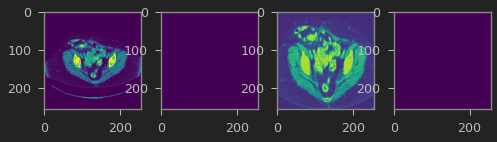

Working on a new scan img0040.nii label0040.nii
original shape (195, 512, 512)
shape after zooming (195, 256, 256)
(195, 256, 256) (195, 256, 256)
(256, 256, 195) (256, 256, 195)
(256, 256, 195)
-125 275
-72.48322448730468 95.2495281240868
-0.5513599547105245 3.0
-0.013576109107702789 0.9539227994826109

47 217 5 248


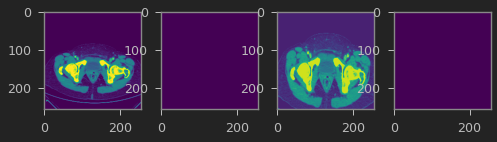

In [9]:
importlib.reload(data_utils)

train_files = []
fn_idx = 0
for imf,labelf in zip(train_images, train_labels):
    print("Working on a new scan", imf, labelf)
    
    scan,labels = preprocess_ct(imf,labelf)
    
    for idx in range(scan.shape[2]):
        # Reshape the images/labels to 256x256xNum_Slices
        X,Y = io.get_consecutive_slices(scan, labels, idx, target_shape=(256,256,3))
        
        # Ignore slices that have none of the target organs present
        if len(np.unique(Y)) == 1 and Y[0,0,0] == 0:
            continue
        
        # Perform data augmentation, for training
        to_save = [(X, Y)]
        for times in range(10):
            to_save.append(aug.combined(X,Y))
        
        # Finally, save the images to tfrecord
        for i in range(len(to_save)):
            fn = "ct_atlas_train_tfs/ct_train_slice" + str(fn_idx) + ".tfrecords"
            train_files.append(fn)
            io.to_tfrecord(to_save[i][0], to_save[i][1], data_dir + fn)
            fn_idx += 1

with open(train_file_list, 'w') as fct_list:
    for item in train_files:
        fct_list.write("%s\n" % item)

im,la = io.sample_batch(data_dir, \
                     train_files, \
                     data_type='mr', \
                     batch_size=30, \
                     seed=0)